# 과적합 해결

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

### 배치 정규화 적용

In [23]:
# 데이터셋 로드
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

In [24]:
# 데이터 분할
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [25]:
class SimpleNN(nn.Module):
    def __init__(self, use_bn=False):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.bn1 = nn.BatchNorm1d(128) if use_bn else nn.Identity()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) if use_bn else nn.Identity()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)    # (배치 크기, h, w) -> (배치 크기, 특성)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [26]:
def train(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        print(f'Epoch {epoch + 1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}')

In [27]:
print('배치 정규화 적용 안함')
model_without_bn = SimpleNN(use_bn=False)
train(model_without_bn, train_loader, val_loader)

print('\n배치 정규화 적용')
model_with_bn = SimpleNN(use_bn=True)
train(model_with_bn, train_loader, val_loader)

배치 정규화 적용 안함
Epoch 1 | Val Loss: 0.2712, Accuracy: 0.9202
Epoch 2 | Val Loss: 0.1769, Accuracy: 0.9473
Epoch 3 | Val Loss: 0.1462, Accuracy: 0.9580
Epoch 4 | Val Loss: 0.1267, Accuracy: 0.9647
Epoch 5 | Val Loss: 0.1286, Accuracy: 0.9620

배치 정규화 적용
Epoch 1 | Val Loss: 0.1141, Accuracy: 0.9675
Epoch 2 | Val Loss: 0.1095, Accuracy: 0.9666
Epoch 3 | Val Loss: 0.0898, Accuracy: 0.9739
Epoch 4 | Val Loss: 0.0830, Accuracy: 0.9742
Epoch 5 | Val Loss: 0.0817, Accuracy: 0.9758


In [28]:
for batch_size in [16, 32, 128]:
    print(f"batch size: {batch_size}")
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    model = SimpleNN(use_bn=True)
    train(model, train_loader, val_loader)

batch size: 16
Epoch 1 | Val Loss: 0.1210, Accuracy: 0.9637
Epoch 2 | Val Loss: 0.0958, Accuracy: 0.9710
Epoch 3 | Val Loss: 0.0916, Accuracy: 0.9718
Epoch 4 | Val Loss: 0.0767, Accuracy: 0.9775
Epoch 5 | Val Loss: 0.0847, Accuracy: 0.9742
batch size: 32
Epoch 1 | Val Loss: 0.1149, Accuracy: 0.9663
Epoch 2 | Val Loss: 0.0930, Accuracy: 0.9722
Epoch 3 | Val Loss: 0.0807, Accuracy: 0.9733
Epoch 4 | Val Loss: 0.0733, Accuracy: 0.9781
Epoch 5 | Val Loss: 0.0746, Accuracy: 0.9768
batch size: 128
Epoch 1 | Val Loss: 0.1312, Accuracy: 0.9647
Epoch 2 | Val Loss: 0.1002, Accuracy: 0.9694
Epoch 3 | Val Loss: 0.0987, Accuracy: 0.9679
Epoch 4 | Val Loss: 0.0813, Accuracy: 0.9752
Epoch 5 | Val Loss: 0.0833, Accuracy: 0.9738


### 드롭아웃 적용

In [29]:
class DropoutNN(nn.Module):
    def __init__(self, dropout_rate):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.dropout1(self.fc1(x)))
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [30]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

for rate in [0.2, 0.5, 0.8]:
    print(f'Dropout Rate: {rate}')
    model = DropoutNN(dropout_rate=rate)
    train(model, train_loader, val_loader)

Dropout Rate: 0.2
Epoch 1 | Val Loss: 0.2350, Accuracy: 0.9304
Epoch 2 | Val Loss: 0.1788, Accuracy: 0.9474
Epoch 3 | Val Loss: 0.1621, Accuracy: 0.9514
Epoch 4 | Val Loss: 0.1344, Accuracy: 0.9621
Epoch 5 | Val Loss: 0.1303, Accuracy: 0.9617
Dropout Rate: 0.5
Epoch 1 | Val Loss: 0.3305, Accuracy: 0.9035
Epoch 2 | Val Loss: 0.2721, Accuracy: 0.9216
Epoch 3 | Val Loss: 0.2477, Accuracy: 0.9262
Epoch 4 | Val Loss: 0.2416, Accuracy: 0.9290
Epoch 5 | Val Loss: 0.2127, Accuracy: 0.9371
Dropout Rate: 0.8
Epoch 1 | Val Loss: 1.3768, Accuracy: 0.7416
Epoch 2 | Val Loss: 1.1410, Accuracy: 0.7532
Epoch 3 | Val Loss: 1.1056, Accuracy: 0.7538
Epoch 4 | Val Loss: 1.0624, Accuracy: 0.7620
Epoch 5 | Val Loss: 1.0665, Accuracy: 0.7295


- 훈련 시 드롭아웃 활성화, 테스트 시 비활성화

In [31]:
def train_do(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        print(f'Epoch {epoch + 1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}')

In [32]:
model = DropoutNN(dropout_rate=0.3)

# train 모드 == 드롭아웃 활성화
model.train()
train_do(model, train_loader, val_loader)

print()

# eval 모드 == 드롭아웃 비활성화
model.eval()
train_do(model, train_loader, val_loader)

Epoch 1 | Val Loss: 0.3761, Accuracy: 0.8913
Epoch 2 | Val Loss: 0.3011, Accuracy: 0.9092
Epoch 3 | Val Loss: 0.2853, Accuracy: 0.9121
Epoch 4 | Val Loss: 0.2684, Accuracy: 0.9215
Epoch 5 | Val Loss: 0.2330, Accuracy: 0.9302

Epoch 1 | Val Loss: 0.1271, Accuracy: 0.9625
Epoch 2 | Val Loss: 0.1179, Accuracy: 0.9643
Epoch 3 | Val Loss: 0.1006, Accuracy: 0.9722
Epoch 4 | Val Loss: 0.1242, Accuracy: 0.9637
Epoch 5 | Val Loss: 0.1074, Accuracy: 0.9690


### Learning Rate Scheduler 적용

In [33]:
class RealSimpleNN(nn.Module):
    def __init__(self):
        super(RealSimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [34]:
def train_lr(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        
        scheduler.step()
        print(f"Epoch {epoch+1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}, LearningRate: {scheduler.get_last_lr()[0]}")

In [35]:
model = RealSimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

train_lr(model, train_loader, val_loader, optimizer, scheduler)

Epoch 1 | Val Loss: 0.2606, Accuracy: 0.9271, LearningRate: 0.01
Epoch 2 | Val Loss: 0.2288, Accuracy: 0.9337, LearningRate: 0.01
Epoch 3 | Val Loss: 0.2576, Accuracy: 0.9288, LearningRate: 0.001
Epoch 4 | Val Loss: 0.1314, Accuracy: 0.9633, LearningRate: 0.001
Epoch 5 | Val Loss: 0.1220, Accuracy: 0.9637, LearningRate: 0.001
Epoch 6 | Val Loss: 0.1206, Accuracy: 0.9640, LearningRate: 0.0001
Epoch 7 | Val Loss: 0.1123, Accuracy: 0.9667, LearningRate: 0.0001
Epoch 8 | Val Loss: 0.1115, Accuracy: 0.9675, LearningRate: 0.0001
Epoch 9 | Val Loss: 0.1115, Accuracy: 0.9671, LearningRate: 1e-05
Epoch 10 | Val Loss: 0.1112, Accuracy: 0.9676, LearningRate: 1e-05


### 조기 종료 적용

In [36]:
def train_es(model, train_loader, val_loader, optimizer, epochs=50, early_stopping=None):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch {epoch + 1} | Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        if early_stopping and early_stopping(val_loss):
            print(f'조기 종료 epoch {epoch + 1}')
            break

    return train_losses, val_losses

In [37]:
# !pip install skorch

In [38]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

In [39]:
model_no_es = RealSimpleNN()
optim_no_es = optim.Adam(model_no_es.parameters(), lr=0.01)
train_losses, val_losses = train_es(model_no_es, train_loader, val_loader, optim_no_es)

model_es = RealSimpleNN()
optim_es = optim.Adam(model_es.parameters(), lr=0.01)
early_stopping = EarlyStopping(patience=5)
train_es_losses, val_es_losses = train_es(model_es, train_loader, val_loader, optim_es, early_stopping=early_stopping)

Epoch 1 | Loss: 0.4156, Accuracy: 0.8672
Epoch 2 | Loss: 0.2707, Accuracy: 0.9202
Epoch 3 | Loss: 0.2576, Accuracy: 0.9265
Epoch 4 | Loss: 0.2629, Accuracy: 0.9262
Epoch 5 | Loss: 0.2420, Accuracy: 0.9319
Epoch 6 | Loss: 0.2082, Accuracy: 0.9437
Epoch 7 | Loss: 0.2353, Accuracy: 0.9348
Epoch 8 | Loss: 0.2616, Accuracy: 0.9286
Epoch 9 | Loss: 0.2347, Accuracy: 0.9393
Epoch 10 | Loss: 0.2231, Accuracy: 0.9381
Epoch 11 | Loss: 0.3196, Accuracy: 0.9187
Epoch 12 | Loss: 0.2182, Accuracy: 0.9421
Epoch 13 | Loss: 0.2340, Accuracy: 0.9373
Epoch 14 | Loss: 0.2433, Accuracy: 0.9375
Epoch 15 | Loss: 0.2307, Accuracy: 0.9415
Epoch 16 | Loss: 0.2393, Accuracy: 0.9376
Epoch 17 | Loss: 0.3183, Accuracy: 0.9180
Epoch 18 | Loss: 0.2311, Accuracy: 0.9436
Epoch 19 | Loss: 0.2526, Accuracy: 0.9366
Epoch 20 | Loss: 0.2542, Accuracy: 0.9374
Epoch 21 | Loss: 0.2350, Accuracy: 0.9448
Epoch 22 | Loss: 0.2197, Accuracy: 0.9447
Epoch 23 | Loss: 0.2521, Accuracy: 0.9392
Epoch 24 | Loss: 0.2511, Accuracy: 0.9357
E

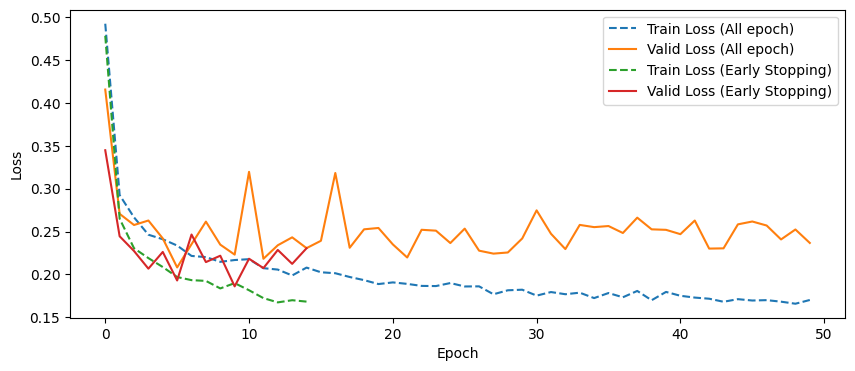

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss (All epoch)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (All epoch)')
plt.plot(train_es_losses, label="Train Loss (Early Stopping)", linestyle='dashed')
plt.plot(val_es_losses, label="Valid Loss (Early Stopping)")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### (L1, )L2 적용

In [46]:
def train_reg(model, train_loader, val_loader, optimizer, epochs=10):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    weight_norms = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch {epoch + 1} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        weight_norm = sum(torch.norm(p).item() for p in model.parameters())
        weight_norms.append(weight_norm)

    return train_losses, val_losses, weight_norms

In [51]:
model_no_reg = RealSimpleNN()
optim_no_reg = optim.SGD(model_no_reg.parameters(), lr=0.01, weight_decay=0.0, momentum=0.9)

train_losses, val_losses, weight_norms = train_reg(model_no_reg, train_loader, val_loader, optim_no_reg)

model_reg = RealSimpleNN()
optim_reg = optim.SGD(model_reg.parameters(), lr=0.01, weight_decay=0.01, momentum=0.9)
train_reg_losses, val_reg_losses, weight_norms_reg = train_reg(model_reg, train_loader, val_loader, optim_reg)

Epoch 1 | Train Loss: 0.4744, Val Loss: 0.2190, Accuracy: 0.9351
Epoch 2 | Train Loss: 0.2033, Val Loss: 0.1702, Accuracy: 0.9517
Epoch 3 | Train Loss: 0.1462, Val Loss: 0.1449, Accuracy: 0.9567
Epoch 4 | Train Loss: 0.1158, Val Loss: 0.1200, Accuracy: 0.9637
Epoch 5 | Train Loss: 0.0986, Val Loss: 0.1084, Accuracy: 0.9683
Epoch 6 | Train Loss: 0.0809, Val Loss: 0.0986, Accuracy: 0.9706
Epoch 7 | Train Loss: 0.0721, Val Loss: 0.1102, Accuracy: 0.9665
Epoch 8 | Train Loss: 0.0643, Val Loss: 0.1010, Accuracy: 0.9703
Epoch 9 | Train Loss: 0.0543, Val Loss: 0.0926, Accuracy: 0.9741
Epoch 10 | Train Loss: 0.0491, Val Loss: 0.0927, Accuracy: 0.9739
Epoch 1 | Train Loss: 0.5078, Val Loss: 0.2942, Accuracy: 0.9179
Epoch 2 | Train Loss: 0.2782, Val Loss: 0.2309, Accuracy: 0.9331
Epoch 3 | Train Loss: 0.2351, Val Loss: 0.2201, Accuracy: 0.9417
Epoch 4 | Train Loss: 0.2130, Val Loss: 0.2100, Accuracy: 0.9417
Epoch 5 | Train Loss: 0.2064, Val Loss: 0.2292, Accuracy: 0.9380
Epoch 6 | Train Loss: 0.

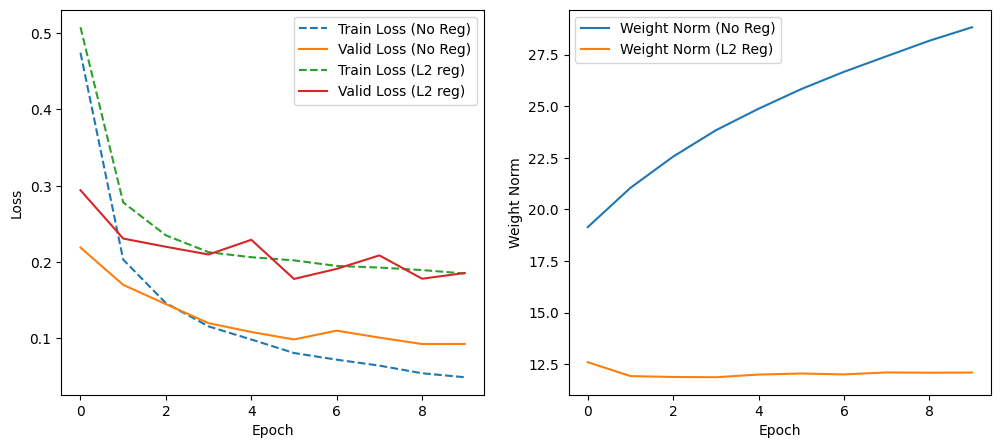

In [52]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss (No Reg)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (No Reg)')
plt.plot(train_reg_losses, label='Train Loss (L2 reg)', linestyle='dashed')
plt.plot(val_reg_losses, label='Valid Loss (L2 reg)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(weight_norms, label='Weight Norm (No Reg)')
plt.plot(weight_norms_reg, label='Weight Norm (L2 Reg)')
plt.xlabel('Epoch')
plt.ylabel('Weight Norm')
plt.legend()

plt.show()